# Building an E-Commerce Clothing Classifier Model


Imagine revolutionizing the fashion and retail industry with cutting-edge AI: as data scientists, we have the opportunity to develop an innovative garment classification system. This project goes beyond mere categorization of clothing items; it's about creating a smarter, more efficient, and user-friendly shopping experience. Leveraging machine learning, specifically image classification, we can transform how consumers interact with fashion online, making it easier to find the perfect outfit among a vast array of choices. By joining this venture, you're not just coding algorithms; you're shaping the future of e-commerce and retail, blending technology with style, and opening up new realms of possibility in the rapidly evolving world of digital fashion.


**Project Instructions:**

- Define a CNN classifier with the following layers:
  - Convolution layer of kernel size 3 and stride 1.
  - RectiLinear unit activation layer.
  - Max pooling layer of kernel size 2 and stride 2.
  - Fully connected layer with the appropriate input and output dimensions.
- Train your CNN on the given train_data using a suitable optimizer.
  - Only run your training loop for 1 or 2 epochs to keep the run time down.
- Test your CNN on the given test_data storing your predictions in a list called predictions.
- Calculate the accuracy, and per-class precision and recall for your trained classifier on the test_data.
  - Store your answers in variables accuracy, precision, and recall respectively. Use lists of the appropriate length for the precision and recall.


In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchmetrics import Accuracy, Precision, Recall
from torchvision import datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [3]:
# Load datasets
train_data = datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transforms.ToTensor()
)
test_data = datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=transforms.ToTensor()
)

In [4]:
print(train_data.data.shape)
print(test_data.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


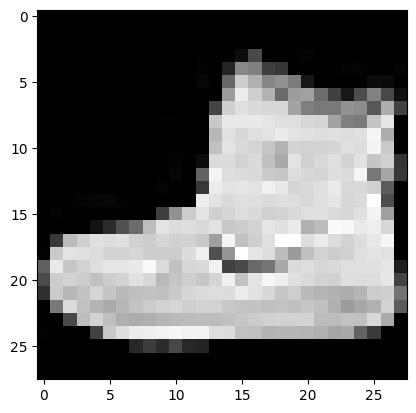

In [5]:
sample_image = train_data.data[0]

plt.imshow(sample_image, cmap="gray")
plt.show()

In [6]:
dataloader_train = DataLoader(dataset=train_data, batch_size=16)
dataloader_test = DataLoader(dataset=test_data, batch_size=16)

In [7]:
output_mapping = {i: v for i, v in enumerate(datasets.FashionMNIST.classes)}
print(output_mapping)

{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}


<class 'matplotlib.axes._axes.Axes'>


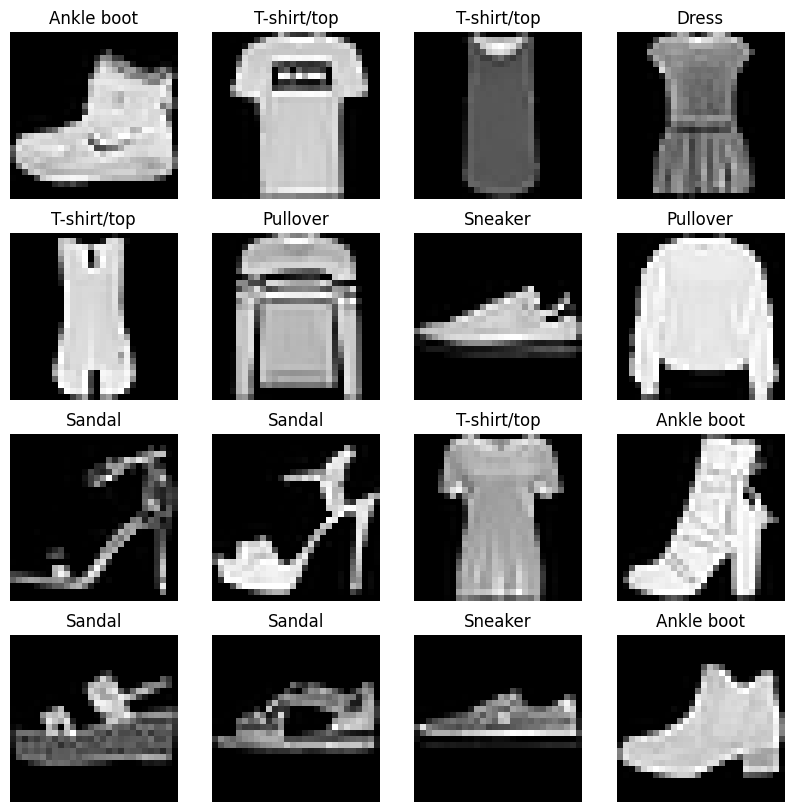

In [8]:
images, labels = next(iter(dataloader_train))

fig, ax = plt.subplots(4, 4, figsize=(10, 10))
print(type(ax[0, 0]))

for i, img in enumerate(images):
    img = img.squeeze()
    label = output_mapping[labels[i].item()]

    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].axis("off")
    ax[i // 4, i % 4].set_title(label)

plt.show()

## Defining the CNN


In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
        )
        # fully conected
        self.fc = nn.Linear(in_features=32*13*13, out_features=10)

    def forward(self, x):
        out = self.feature_extractor(x)
        out = self.fc(out)
        return out

In [10]:
images, labels = next(iter(dataloader_train))
img = images[0]

conv = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1)
out = conv(img)

relu = nn.ReLU()
out = relu(out)
print(out.size())
maxp = nn.MaxPool2d(kernel_size=2, stride=2, dilation=1, padding=0)
out = maxp(out)

print(out.size())

torch.Size([32, 26, 26])
torch.Size([32, 13, 13])


## Training the CNN


In [12]:
# Define the model
net = Net()

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(params=net.parameters(), lr=0.0001)

In [13]:
for epoch in range(2):
    running_loss = 0.0
    # Iterate over training batches
    for images, labels in dataloader_train:
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader_train)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

Epoch 1, Loss: 0.5900
Epoch 2, Loss: 0.3949


## Testing the CNN


In [30]:
metric_accuracy = Accuracy(task="multiclass", num_classes=10, average="micro")
metric_recall = Recall(task="multiclass", num_classes=10, average=None)
metric_precision = Precision(task="multiclass", num_classes=10, average=None)

net.eval()

predicted = []

with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        predicted.extend(preds)
        metric_accuracy(preds, labels)
        metric_recall(preds, labels)
        metric_precision(preds, labels)

accuracy = metric_accuracy.compute()
recall = metric_recall.compute()
precision = metric_precision.compute()

print(f"Accuracy: {accuracy}")

# Get precision per class
recall_per_class = {k: recall[v].item() for k, v in test_data.class_to_idx.items()}

print(recall_per_class)

precision_per_class = {
    k: precision[v].item() for k, v in test_data.class_to_idx.items()
}
print(precision_per_class)

recall = recall.tolist()
precision = precision.tolist()

Accuracy: 0.863099992275238
{'T-shirt/top': 0.8370000123977661, 'Trouser': 0.9520000219345093, 'Pullover': 0.8489999771118164, 'Dress': 0.9240000247955322, 'Coat': 0.7770000100135803, 'Sandal': 0.9369999766349792, 'Shirt': 0.4959999918937683, 'Sneaker': 0.9559999704360962, 'Bag': 0.9629999995231628, 'Ankle boot': 0.9399999976158142}
{'T-shirt/top': 0.8118331432342529, 'Trouser': 0.9947753548622131, 'Pullover': 0.7225531935691833, 'Dress': 0.8140969276428223, 'Coat': 0.7731343507766724, 'Sandal': 0.9719917178153992, 'Shirt': 0.742514967918396, 'Sneaker': 0.9001883268356323, 'Bag': 0.942270040512085, 'Ankle boot': 0.9582059383392334}


[0.8370000123977661, 0.9520000219345093, 0.8489999771118164, 0.9240000247955322, 0.7770000100135803, 0.9369999766349792, 0.4959999918937683, 0.9559999704360962, 0.9629999995231628, 0.9399999976158142]
